In [1]:
import pandas as pd
import numpy as np

In [2]:
pip install keras

In [3]:
from __future__ import print_function
import numpy as np
import h5py
import glob
import math
from sklearn import metrics 
from keras.metrics import accuracy

import os
import shutil
from scipy import signal
from scipy.signal import butter, lfilter
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv1D, MaxPooling1D, UpSampling1D, Flatten, Dropout, Reshape 
from keras.layers import Bidirectional, BatchNormalization, ZeroPadding1D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from tensorflow.keras.optimizers import SGD, Adam
from keras import regularizers
from keras.layers import (Dense, Dropout, Activation, Flatten, Reshape, Layer,
                          BatchNormalization, LocallyConnected2D, AveragePooling1D,
                          ZeroPadding2D, Conv2D, MaxPooling2D, Conv2DTranspose,
                          GaussianNoise, UpSampling2D, Input, InputSpec)
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
from keras.initializers import VarianceScaling
from keras.callbacks import CSVLogger
from scipy.optimize import linear_sum_assignment as linear_assignment
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics 
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')

In [4]:
df = pd.read_parquet('/content/drive/MyDrive/TB06_data/r206n05.gzip')


In [ ]:
df.head()

In [6]:
df = df.drop(['label','timestamp'],axis=1)

In [48]:
df.describe()


,avg:ambient,var:ambient,max:ambient,min:ambient,avg:dimm0_temp,var:dimm0_temp,max:dimm0_temp,min:dimm0_temp,avg:dimm10_temp,var:dimm10_temp,...,min:proc_total,avg:swap_free,var:swap_free,max:swap_free,min:swap_free,avg:swap_total,var:swap_total,max:swap_total,min:swap_total,New_label
count,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,...,15310.000000,1.531000e+04,1.531000e+04,1.531000e+04,1.531000e+04,15310.0,15310.0,15310.0,15310.0,15310.000000
mean,18.716309,0.041324,18.940888,18.489288,27.082400,0.073318,27.264533,26.897257,27.616306,0.062888,...,2461.721816,3.586335e+06,5.954080e+08,3.587052e+06,3.585617e+06,4194240.0,0.0,4194240.0,4194240.0,0.049510
std,2.482816,0.097875,2.505538,2.466572,2.421890,0.142473,2.452004,2.409420,2.378890,0.161412,...,554.162798,4.641056e+05,2.908237e+10,4.617490e+05,4.674183e+05,0.0,0.0,0.0,0.0,0.310766
min,10.426667,0.000000,10.600000,10.000000,20.266667,0.000000,21.000000,20.000000,20.000000,0.000000,...,1235.000000,7.561143e+03,0.000000e+00,1.664000e+04,0.000000e+00,4194240.0,0.0,4194240.0,4194240.0,0.000000
25%,16.986667,0.008381,17.200000,16.800000,25.000000,0.000000,25.000000,25.000000,26.000000,0.000000,...,2093.000000,3.279424e+06,0.000000e+00,3.279424e+06,3.279424e+06,4194240.0,0.0,4194240.0,4194240.0,0.000000
50%,18.586667,0.014095,18.800000,18.400000,27.000000,0.000000,27.000000,27.000000,28.000000,0.000000,...,2240.500000,3.600128e+06,0.000000e+00,3.600128e+06,3.600128e+06,4194240.0,0.0,4194240.0,4194240.0,0.000000
75%,20.613333,0.036952,21.000000,20.200000,29.000000,0.123810,29.000000,29.000000,29.000000,0.066667,...,2698.000000,4.194240e+06,0.000000e+00,4.194240e+06,4.194240e+06,4194240.0,0.0,4194240.0,4194240.0,0.000000
max,25.226667,4.300952,25.400000,25.200000,33.000000,4.409524,33.000000,33.000000,33.933333,8.638095,...,3804.000000,4.194240e+06,1.835336e+12,4.194240e+06,4.194240e+06,4194240.0,0.0,4194240.0,4194240.0,2.000000


In [45]:
df.isna().any()


avg:ambient       False
var:ambient       False
max:ambient       False
min:ambient       False
avg:dimm0_temp    False
                  ...  
avg:swap_total    False
var:swap_total    False
max:swap_total    False
min:swap_total    False
New_label         False
Length: 461, dtype: bool

In [49]:
df.isnull().sum()


avg:ambient       0
var:ambient       0
max:ambient       0
min:ambient       0
avg:dimm0_temp    0
                 ..
avg:swap_total    0
var:swap_total    0
max:swap_total    0
min:swap_total    0
New_label         0
Length: 461, dtype: int64

In [7]:
X = df.drop('New_label',axis=1)
y = df.New_label

In [ ]:
y

In [9]:
y = y.apply(lambda x: 1 if x == 2 else 0)


In [10]:
y[y==1]

index
3015     1
3018     1
3021     1
3024     1
3027     1
        ..
95211    1
95214    1
95217    1
95220    1
95223    1
Name: New_label, Length: 379, dtype: int64

In [52]:
y.value_counts()

0    14931
1      379
Name: New_label, dtype: int64

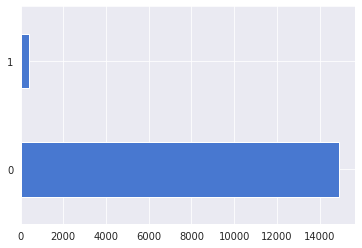

In [51]:
y.value_counts().plot(kind='barh')


In [12]:
X.shape

(15310, 460)

In [13]:
from sklearn.preprocessing import MinMaxScaler

columns = list(X.columns.values)
scaler = MinMaxScaler() 
X[columns] = scaler.fit_transform(X[columns])
X.head()

,avg:ambient,var:ambient,max:ambient,min:ambient,avg:dimm0_temp,var:dimm0_temp,max:dimm0_temp,min:dimm0_temp,avg:dimm10_temp,var:dimm10_temp,...,max:proc_total,min:proc_total,avg:swap_free,var:swap_free,max:swap_free,min:swap_free,avg:swap_total,var:swap_total,max:swap_total,min:swap_total
index,,,,,,,,,,,,,,,,,,,,,
27,0.738323,0.023489,0.756757,0.710526,0.770439,0.017445,0.833333,0.769231,0.645933,0.0,...,0.304531,0.309848,0.856535,0.000000e+00,0.856224,0.856794,0.0,0.0,0.0,0.0
30,0.740402,0.044117,0.770270,0.710526,0.782521,0.043612,0.833333,0.769231,0.645933,0.0,...,0.306068,0.309848,0.856560,6.695233e-10,0.856254,0.856809,0.0,0.0,0.0,0.0
33,0.725849,0.018362,0.743243,0.710526,0.764398,0.000000,0.750000,0.769231,0.645933,0.0,...,0.304531,0.310237,0.856581,0.000000e+00,0.856270,0.856840,0.0,0.0,0.0,0.0
36,0.755994,0.019316,0.770270,0.723684,0.794603,0.058149,0.833333,0.769231,0.645933,0.0,...,0.306068,0.310627,0.856612,0.000000e+00,0.856300,0.856870,0.0,0.0,0.0,0.0
39,0.724809,0.040540,0.756757,0.697368,0.764398,0.000000,0.750000,0.769231,0.645933,0.0,...,0.305300,0.308680,0.856627,0.000000e+00,0.856316,0.856886,0.0,0.0,0.0,0.0


In [14]:
X.shape


(15310, 460)

In [15]:
y.shape

(15310,)

#Models

In [16]:
X = np.expand_dims(X, axis=2)

In [122]:
# X = np.expand_dims(X, axis=3)

In [17]:
X.shape

(15310, 460, 1)

In [124]:
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
Pre_train_optimizer = SGD(learning_rate=0.1, momentum=0.9)


In [18]:
# Conv1 #
input_img = Input(shape=(460, 1, 1))  
x = Conv2D(filters = 16, kernel_size = (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D(pool_size = (2, 2), padding='same')(x)

# Conv2 #
x = Conv2D(filters = 8, kernel_size = (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size = (2, 2), padding='same')(x) 

# Conv 3 #
x = Conv2D(filters = 8, kernel_size =(3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D(pool_size = (2, 2), padding='same')(x)

# Note:
# padding is a hyper-arameter for either 'valid' or 'same'. 
# "valid" means "no padding". 
# "same" results in padding the input such that the output has the same length as the original input.
############
# Decoding #
############

# DeConv1
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)

# DeConv2
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

# Deconv3
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

In [19]:
# from keras import backend as K 
# def euc_dist_keras(y_true, y_pred):
#     return K.sqrt(K.sum(K.square(y_true - y_pred), axis=-1, keepdims=True))

In [54]:
autoencoder = Model(input_img, decoded)
encoder =Model(input_img, encoded)
autoencoder.compile(optimizer=Pre_train_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [55]:
encoder.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 460, 1, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 460, 1, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 230, 1, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 230, 1, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 115, 1, 8)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 115, 1, 8)         584 

In [56]:
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 460, 1, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 460, 1, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 230, 1, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 230, 1, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 115, 1, 8)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 115, 1, 8)         584 

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)
from IPython.display import Image
Image(filename='autoencoder.png')

In [58]:
autoencoder.fit(X, X,
                epochs=100,
                batch_size=128,
                verbose=1,
                shuffle=True)

Epoch 1/100
120/120 [==============================] - 2s 8ms/step - loss: 0.7216 - accuracy: 0.1847
Epoch 2/100
120/120 [==============================] - 1s 7ms/step - loss: 0.5956 - accuracy: 0.1878
Epoch 3/100
120/120 [==============================] - 1s 7ms/step - loss: 0.5954 - accuracy: 0.1878
Epoch 4/100
120/120 [==============================] - 1s 7ms/step - loss: 0.5954 - accuracy: 0.1878
Epoch 5/100
120/120 [==============================] - 1s 7ms/step - loss: 0.5953 - accuracy: 0.1878
Epoch 6/100
120/120 [==============================] - 1s 7ms/step - loss: 0.5953 - accuracy: 0.1878
Epoch 7/100
120/120 [==============================] - 1s 7ms/step - loss: 0.5951 - accuracy: 0.1878
Epoch 8/100
120/120 [==============================] - 1s 7ms/step - loss: 0.5952 - accuracy: 0.1878
Epoch 9/100
120/120 [==============================] - 1s 7ms/step - loss: 0.5948 - accuracy: 0.1878
Epoch 10/100
120/120 [==============================] - 1s 7ms/step - loss: 0.5947 - accura

In [33]:

pred = encoder.predict(X)


In [36]:
pred=pred.reshape(15310,58*8)

In [37]:
pred.shape

(15310, 464)

In [38]:
score_2 = []
range_values = range(1, 20)
for i in range_values:
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(pred)
    score_2.append(kmeans.inertia_)

<function matplotlib.pyplot.show>

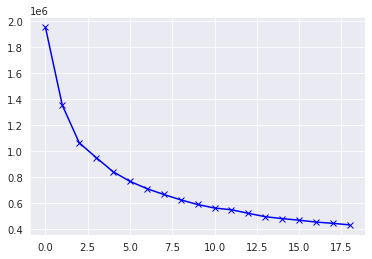

In [39]:
plt.plot(score_2, 'bx-', color = 'b', label = 'Compressed Data')
plt.show

In [40]:
kmeans = KMeans(2)
kmeans.fit(pred)
labels = kmeans.labels_

In [41]:
pca = PCA(n_components = 2)
prin_comp = pca.fit_transform(pred)
pca_df = pd.DataFrame(data = prin_comp, columns = ['pca1', 'pca2'])

In [42]:
pca_df = pd.concat([pca_df, pd.DataFrame({'cluster': labels})], axis = 1)
pca_df.head()

,pca1,pca2,cluster
0,-2.079948,-1.830216,0
1,-2.221185,-1.621440,0
2,-2.371474,-1.691595,0
3,-2.296585,-1.402319,0
4,-2.249901,-1.679446,0


Text(0, 0.5, 'pca2')

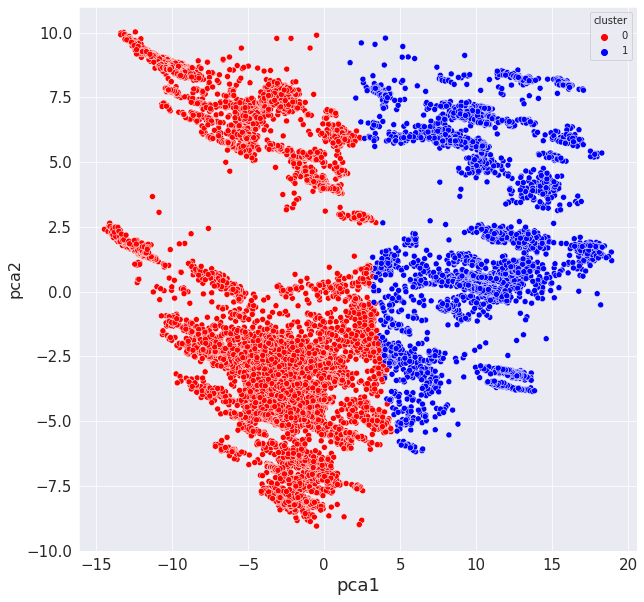

In [43]:
plt.figure(figsize = (10, 10))
ax = sns.scatterplot(x = 'pca1', y = 'pca2', hue = 'cluster', data = pca_df, palette = ['red', 'blue'], )
ax.tick_params(axis='both', which='major', labelsize = 15)
plt.xlabel('pca1', fontsize=18)
plt.ylabel('pca2', fontsize=16)